# Gaussian Mixture Model (GMM)

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd

# from sklearn.datasets.samples_generator import make_blobs # 舊版寫法，已不能使用
from sklearn.datasets import make_blobs

from sklearn.cluster import KMeans
# from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

In [7]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis', alpha = 0.5, zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.8, zorder=1))

In [125]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, covariance_type="full", label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    centers = gmm.means_
    
    ax.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5, zorder = 3);
    
    w_factor = 0.2 / gmm.weights_.max()
    
    if covariance_type == "spherical":
        cov_right_shape = np.array([np.identity(2) * eta for eta in gmm.covariances_])
    elif covariance_type == "diag":
        cov_right_shape = np.array([np.diagflat(eta) for eta in gmm.covariances_])
    elif covariance_type == "tied":
        cov_right_shape = np.array([gmm.covariances_ for i in range(gmm.n_components)])
    else:
        cov_right_shape = gmm.covariances_
    
    for pos, covar, w in zip(centers, cov_right_shape, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

## Toy Example (多維, 多群)

### 產生資料並先試試 KMeans

In [17]:
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

# 看資料的維度
print(X_stretched.shape)
# 看資料的前五筆
print(X_stretched[:5]) 

(400, 2)
[[-4.63330948  5.00361975]
 [-1.67654295  0.68197545]
 [-2.05710285  1.00284771]
 [-3.10473256  3.56955705]
 [-1.58585158  0.65172436]]


* 可以看到這是筆 400x2 的 data，feature 只有 2 維  
* 畫個圖先看一下資料分布

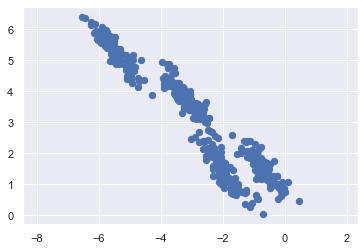

In [19]:
ax = plt.gca()
ax.axis('equal')
ax.scatter(X_stretched[:, 0], X_stretched[:, 1], s=40, cmap='viridis');

* 可以發現，資料分布看起來是 4 群  
* 但有別於之前看過的例子，現在每一群的分配，比較像斜橢圓，而不是正圓. 
* 那如果繼續用 KMeans 來分群，結果會如何呢？

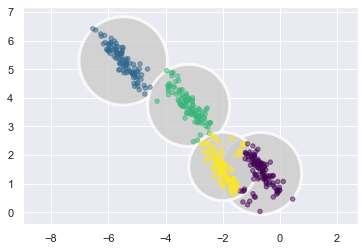

In [20]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

* 可以發現，第三群 和 第四群分的並不好。
* 這是因為，這兩群的圓出現了 overlap。所以交集的點，有些被分到左邊，有些被分到右邊。
* 這可以理解，因為每一群的點，看起來不是正圓，和 KMeans 的假設不合。
* 那我們試試有沒有辦法對資料做前處理，想辦法先讓他變正圓，再來做 KMeans. 
  * 先各個 feature 做 Normalization. (先讓 x,y 方向散的一樣開，此時會是 scale 相同的橢圓)
  * 再做 PCA (把橢圓躺下來，變正圓)

column means:  [7.20534743e-16 1.94289029e-16]
column sd:  [1. 1.]
cor of two feature: 
[[ 1.         -0.94271845]
 [-0.94271845  1.        ]]


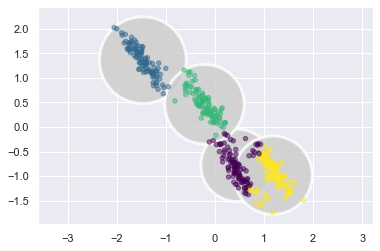

In [46]:
col_normalizer = StandardScaler()
X_stretch_norm = col_normalizer.fit_transform(X_stretched)
print("column means: ", X_stretch_norm.mean(axis = 0))
print("column sd: ", X_stretch_norm.std(axis = 0))
print("cor of two feature: ")
print(np.corrcoef(X_stretch_norm[:,0], X_stretch_norm[:,1]))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretch_norm)

* 可以發現，效果沒變。還是分不好. 
* 甚至，看最左上角那群，他在 y 方向散的比較開， x 方向散的比較窄。
* 理論上，做完標準化後，應該在兩個方向要散的一樣開，但為啥會這樣？  
  * 那是因為，我們是對 `整個` 資料集做標準化，不是對個別的群做標準化。  
  * 所以可以看到，對整個資料集來說，做完前處理後，兩個 feature 的平均數都是 0 ，標準差都是 1，兩個 feature 的相關性是 -0.94. 
  * 這也反映在整張圖的點，x 和 y 方向散的一樣開，正中心在 (0,0)  
  * 但這無濟於事，因為我是希望群內做標準化，才能讓他散的一樣開。but，你就還沒分群，當然無法做群內標準化。這流於雞生蛋，蛋生雞。
* 接下來，繼續做 PCA 看看

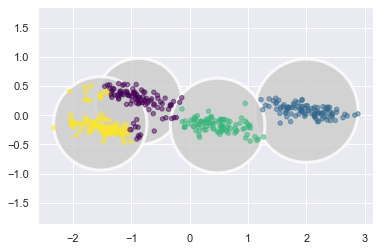

In [27]:
pca = PCA(n_components = 2)
X_stretch_norm_pca = pca.fit_transform(X_stretch_norm)

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretch_norm_pca)

* 可以發現，橢圓都躺下來了，但還是無法解決 overlap 的問題. 
* 理由同上，如果我們可以對各個群，自己做 Normalization + PCA，就能解決，但...我現在就是不知道各自屬於哪一群。  

### 從 KMeans 改到 GMM 的動機

* 從上面的範例，大概可以了解 KMeans 的致命缺點了：  
  * 每一群的資料，必須分佈成正圓，才能分得好。(對於不是正圓的資料，做前處理也未必能轉換成正圓，最終無解。)    
  * 對於 overlap 的點，我們只能強硬的幫他分到某一類，我沒辦法指出，這些 overlap 的點，有多少機率來自第一群/第二群/.../第ｋ群  
* 而 GMM，作為 KMeans 的延伸，就是可以來解決以上兩點：  
  * 每一群的資料，是正圓或橢圓都沒關係。
  * 每一個點，我都可以給出，他屬於 K 個群的各自可能性

### 概念講解

* 之後整理，我覺得重點是以下幾個：  

#### <span style="color: blue">資料生成模型</span>

* 每一個資料點，都假設來自以下的 mixture of Gaussian distribution:  
  * $X_i \ \ iid \ \  \sim p_1*N(\mu_1, \Sigma_1)+p_2*N(\mu_2, \Sigma_2)+...+ p_K*N(\mu_K, \Sigma_K)$  
  * 這個分佈，可以用各種角度來想 (先假設資料只有 1 維就好，那就是多峰的 Normal)：  
    * 以 density 的形狀來說，他就像各種 normal訊號 的線性組合結果，$p_k$ 就是權重. 
    * 以蒐集到 100 筆的資料後來想，就表示第k群的資料量，佔全部資料的 $p_k$ 比例  
    * 以生成一筆新資料來說，就是有 $p_k$ 比利的可能性，會從 第k群 的 normal 來生出一筆資料. 
* 我覺得，用資料生成的圖，更好理解這個過程。假設我們現在想生成一筆 data，過程如下：  
  * 先從 $S_i \sim Categorical(p_1, p_2, ..., p_k)$ 的分佈中，生成 $S_i = k$，k=1,2,...,K，就可以知道這筆資料來自哪一組. 
  * 再從 $(X_i|S_i = k) \sim N(\mu_k, \Sigma_k)$ 的分佈中，生成 $X_i = x_i$  
* 那我們現在要做參數估計時，就是上面的倒過來：  
  * 已經收到 $x_i, i = 1,2, ..., N$ 的資料. 
  * 哪一組參數，最可能產出我手上收到的這筆資料？

#### <span style="color: blue">參數估計</span>

* 要估計的參數，包括：  
  * mixture 的權重： $K-1$ 個 (因為只要知道 K-1 個權重，最後一個用 1 - 大家就好)
  * K 個 $mu$ vector： $K \times p$ 個. 
  * K 個 $\Sigma$ matrix: $K \times \frac{p \times (p+1)}{2}$
  * 總計： $\frac{1}{2} \times K \times (P+1) \times (P+2) - 1$
* 令 $\Theta = (p_1,...,p_K,\mu_1,\Sigma_1,...,\mu_K, \Sigma_K)$，則每一資料，生成的 pdf 如下：

$$
f_{Mix}(x_i|\Theta) = \sum_{k=1}^K p_k \frac{1}{(2\pi)^{\frac{p}{2}}|\Sigma_k|^{\frac{1}{2}}} exp \left\{ -\frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) \right\}
$$

* 收到 N 筆資料， join pdf (i.e. likelihood) 如下：

$$
L(\Theta | X) = \prod_{i=1}^N f_{Mix}(x_i|\Theta)
$$

* 經過一番參數估計後(會用 EM 演算法，詳情參考之前統算推導)，就可以得到
  * 一組參數估計值： $\hat{\Theta} = arg \ max L(\Theta|X)$  
  * 一個 max likelihood 的值: $L_{max} = L(\hat{\Theta}|X)$  
  * 以及估計的參數個數

##### <span style="color: blue"> 選 $\Sigma$ 限制式</span>

* 剛剛在做參數估計時，對 $\Sigma$，是沒有限制式的。 
* 但其實沒有限制式的話，很可能造成要估計的參數過多(大過sample數)，而造成無法估計。
* 所以，會做以下的限制

|  $\Sigma_k$   | 限制式意義  | `covariance_type` <br> (在 sklearn 的參數名稱) | 參數個數 | 備註 |
|  ----  | ----  |  ----  | ----  | ----  |
| $\eta I$  | 每一群都是相同的正圓 | a | K(p+1) |
| $\eta_k \ I$ | 每一群是不同的正圓 | `spherical` |  K(p+2) -1 | KMeans 在這 |
| $\eta_k$ Diag ($\lambda_1$,...,$\lambda_p$) | 每一群是不同的正橢圓 | `diag` | K(p+2) + p -1 |
| $\Sigma$ | 每一群都是同一個斜橢圓 | `tied` | K-1 + K(px(p+1)/2) |
| $\Sigma_k$ (無限制)  | 每一群是不同的斜橢圓 | `full` | $\frac{1}{2}$K(p+1)(p+2) - 1 |

##### <span style="color: blue"> 選 k </span>

* 給定一個 k 後，就可以做上面的參數估計，估計完後，就可以得到 max liklihood 的值  
* 可以想像， k 如果給越大， likelihood 會越好，但就越容易 overfitting. 
* 所以，可以用 `AIC` or `BIC` 這兩個指標，來幫我們選模  
  * $AIC = -2 \ ln \ L_{max} + 2 \times$ (number of parameters estimated) -> $\hat{k} = arg \ min AIC$ 
  * $BIC = -2 \ ln \ L_{max} + ln(N) \times$ (number of parameters estimated) -> $\hat{k} = arg \ min BIC$ 

#### <span style="color: blue">預測(分群)</span>

* 再來，就可以預估手上這筆 data，來自各群的可能性了，怎做？ -> 用 posterior distribution 來處理：  

$$
\hat{\theta}_k^{(i)} = P(S_i = k|x_i) = \frac{P(x_i|S_i=k)P(S_i=k)}{\sum_{j=1}^K P(x_j|S_j=k)P(S_j=k)} = \frac{\hat{f_k} (x_i) \ \hat{p_k}}{\sum_{j=1}^K \hat{f_k} (x_i) \ \hat{p_k}}
$$

* 經由上式，就得到 第i組 data，他在第 k 群的可能性。那跑遍 K 群，就得到他在每一群的預測值: $(\hat{\theta}_1^{(i)},\hat{\theta}_2^{(i)},...,\hat{\theta}_K^{(i)})$
* 接下來，有兩種方式可以給出 硬分群 的結果. 
  * 從 $Multinominal(n=1, \hat{\theta}_1^{(i)},\hat{\theta}_2^{(i)},...,\hat{\theta}_K^{(i)})$ 中，抽出一筆，可能值就是 1 or 2 or ,,, or K，那這就是預測群組了. 
  * 直接找最大的就好： $\hat{k} = arg max \{ \hat{\theta}_1^{(i)},\hat{\theta}_2^{(i)},...,\hat{\theta}_K^{(i)} \}$

### code 實作

#### 資料

* 再來看一下剛剛的範例資料：

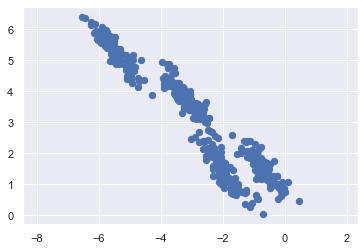

In [47]:
ax = plt.gca()
ax.axis('equal')
ax.scatter(X_stretched[:, 0], X_stretched[:, 1], s=40, cmap='viridis');

In [48]:
X_stretched.shape

(400, 2)

#### training

In [50]:
gm = GaussianMixture(n_components=4, n_init=10)
gm.fit(X_stretched);

* 看一下參數估計是否收斂：

In [59]:
print("是否收斂？ ", gm.converged_)
print("EM iteration了幾次", gm.n_iter_)

是否收斂？  True
EM iteration了幾次 6


* 看一下參數估計的結果：

In [56]:
print("p hat: ", gm.weights_)
print("mu hat: ")
print(gm.means_)
print("Sigma hat: ")
print(gm.covariances_)

p hat:  [0.24960937 0.24856308 0.24726764 0.25455991]
mu hat: 
[[-0.68373205  1.51591598]
 [-5.4736886   5.27447425]
 [-1.95405049  1.40907606]
 [-3.15090783  3.71109673]]
Sigma hat: 
[[[ 0.15012765 -0.15798472]
  [-0.15798472  0.22221707]]

 [[ 0.18632125 -0.20655164]
  [-0.20655164  0.27558183]]

 [[ 0.19777594 -0.22402528]
  [-0.22402528  0.31418505]]

 [[ 0.20718288 -0.22448647]
  [-0.22448647  0.30342679]]]


* 看起來美賣：  
  * 分成 4 群，每一群的比例都差不多是 0.25。這和我從圖上看到的比例很像。  
  * mu_hat 給我 4 組 mean vector，這等等畫圖再來看估得好不好. 
  * Sigma hat 給我 4 個 covariance matrix，而且看起來都沒被限制 (因為 default 是 `covariance_type = 'full'`)，可以想像等等會畫出 4 個不同的斜橢圓. 

#### prediction(分群)

* 我們可以先做 軟分群：

In [63]:
gm_pred_prob = gm.predict_proba(X_stretched)
gm_pred_prob

array([[1.57650321e-22, 4.25123071e-01, 2.55374096e-07, 5.74876674e-01],
       [4.53546582e-15, 1.90957124e-17, 9.99999999e-01, 1.06652119e-09],
       [2.92853046e-17, 2.34378258e-14, 9.99999998e-01, 2.37101929e-09],
       ...,
       [9.99999920e-01, 1.08972061e-36, 2.05299504e-08, 5.89991829e-08],
       [3.68290892e-04, 2.08418557e-15, 4.45517666e-01, 5.54114043e-01],
       [1.00000000e+00, 3.80709722e-47, 5.71567299e-14, 1.76093911e-11]])

* 可以看到，第一個 sample，他在 k 個群上的預測機率。
* 我們可以找出最大值在哪：

In [64]:
np.argmax(gm_pred_prob[0])

3

* 可以得知，他是 index = 3 這一群

* 如果要做 硬分群，就這樣做就好：

In [67]:
#gm_pred = gm.predict(X_stretched)
gm_pred = np.argmax(gm_pred_prob, axis = -1)
gm_pred

array([3, 2, 2, 3, 2, 1, 0, 3, 2, 0, 1, 0, 3, 2, 2, 0, 2, 0, 3, 2, 2, 2,
       1, 3, 3, 1, 1, 3, 3, 0, 3, 3, 2, 3, 2, 1, 0, 3, 0, 3, 2, 1, 0, 3,
       0, 1, 0, 0, 0, 1, 1, 1, 2, 1, 1, 2, 3, 0, 0, 2, 0, 0, 0, 0, 3, 2,
       0, 3, 2, 1, 2, 3, 2, 1, 0, 2, 3, 2, 1, 2, 2, 3, 0, 1, 3, 2, 2, 3,
       2, 0, 2, 0, 3, 2, 2, 1, 3, 0, 0, 0, 1, 0, 3, 3, 2, 1, 3, 1, 0, 2,
       2, 2, 3, 2, 1, 0, 1, 2, 1, 1, 0, 2, 0, 1, 3, 1, 0, 0, 0, 3, 1, 1,
       1, 2, 3, 2, 1, 3, 1, 2, 3, 2, 2, 1, 2, 0, 3, 2, 0, 2, 0, 3, 0, 3,
       1, 2, 0, 2, 2, 2, 3, 2, 1, 2, 2, 1, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0,
       3, 2, 3, 1, 3, 1, 2, 3, 1, 2, 1, 3, 3, 1, 3, 3, 1, 2, 1, 1, 1, 0,
       0, 3, 3, 2, 0, 0, 1, 3, 2, 1, 3, 1, 3, 3, 0, 0, 1, 0, 3, 1, 0, 1,
       2, 3, 1, 2, 2, 2, 0, 1, 3, 1, 3, 2, 3, 3, 1, 0, 2, 0, 3, 2, 0, 3,
       3, 1, 0, 3, 1, 3, 0, 2, 2, 0, 2, 3, 1, 1, 3, 3, 0, 1, 3, 2, 2, 2,
       1, 3, 3, 3, 3, 3, 0, 3, 3, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 3, 0, 3, 0, 2, 3, 0, 2, 3, 0, 0, 3, 2, 1,

#### 視覺化

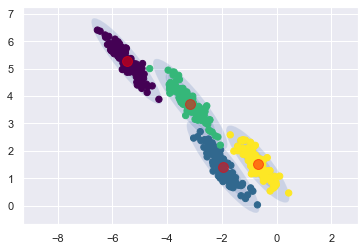

In [100]:
gm = GaussianMixture(n_components=4, n_init=10)
plot_gmm(gm, X_stretched)

* 水啦～ 分的將將好

#### 不同 covariance 限制式的影響

* 剛剛在估計 covariance matrix 時，是沒有設限制式的。  
* 我們現在來試試看，如果用和 KMeans 幾乎等價的限制式 (covariance_type = 'spherical') 會怎麼樣：

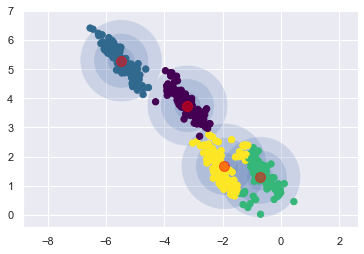

In [99]:
gm_spherical = GaussianMixture(
    n_components = 4,
    n_init = 10,
    covariance_type = 'spherical'
)

plot_gmm(gm_spherical, X_stretched, covariance_type = "spherical")

* 果然跟 KMeans 的結果一樣  
* 那如果換成 `covariance_type = 'diag'`，就換變成用正橢圓來分類，結果預計也不會太好

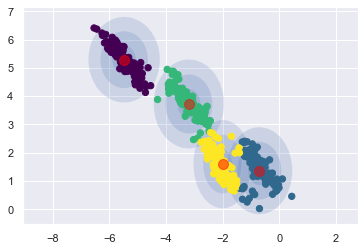

In [109]:
gm_diag = GaussianMixture(
    n_components = 4,
    n_init = 10,
    covariance_type = 'diag'
)
#gm_diag.fit(X_stretched);
plot_gmm(gm_diag, X_stretched, covariance_type = "diag")

* 可以看到，結果果然不怎樣，他送出了 4 個直橢圓  
* 接著試試看，如果限制大家都是同一個斜橢圓 (covariance_type = 'tied')

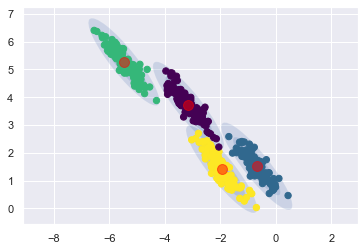

In [127]:
gm_tied = GaussianMixture(
    n_components = 4,
    n_init = 10,
    covariance_type = 'tied'
)
plot_gmm(gm_tied, X_stretched, covariance_type = "tied")

* 讚拉！ 而且這筆模擬資料，看起來的確各個組的 covariance matrix 都差不多

#### 選群數，選 cov 限制式

* 剛剛都是直接指定 k = 4，現在來用 AIC 和 BIC 選選看：

In [114]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

arg_min_aic = np.argmin(aics) + 1
arg_min_bic = np.argmin(bics) + 1

print("arg min aic = ", arg_min_aic)
print("arg min bic = ", arg_min_bic)

arg min aic =  4
arg min bic =  4


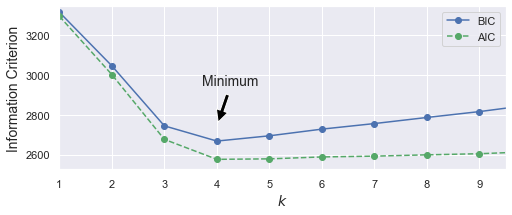

In [115]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(arg_min_aic, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
# save_fig("aic_bic_vs_k_plot")
# plt.show()

* 可以得知，選 k = 4 是較好的

* 最後，我們可以同時把 k 和 covariance_type 都當作 hyper-parameter，然後用 BIC 找出最好的組合：

In [116]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [117]:
print("best k is: ", best_k)
print("best_covariance_type: ", best_covariance_type)

best k is:  4
best_covariance_type:  tied


* 結果還不錯，看來大家共用同樣的 covariance matrix，就可以估的很好了 (分群分的 ok ，而且參數比 full 更精簡)

#### 產生資料 與 density estimation

* 當我們 fit 完 GMM 後，等於得到了一個 pdf. 
* 有這個 pdf，我要生成新資料，或是去算 density 就都很方便了：

In [131]:
# final model
gmm_tied = GaussianMixture(
    n_components = 4,
    n_init = 10,
    covariance_type = 'tied'
)
gmm_tied.fit(X_stretched);

# 隨機生成 5 筆 data
X_new, y_new = gmm_tied.sample(5)
print("生成5筆資料")
print(X_new)
print("此五筆資料來自的 cluster")
print(y_new)
print("此五筆資料的 density")
print(np.exp(gmm_tied.score_samples(X_new)))

生成5筆資料
[[-0.36581533  0.85440405]
 [-5.37152264  5.12592459]
 [-5.33699891  5.03877372]
 [-1.48330776  1.04367111]
 [-2.22834881  2.62981916]]
此五筆資料來自的 cluster
[0 1 1 2 3]
此五筆資料的 density
[0.12417672 0.3755171  0.34741156 0.17303794 0.03868295]


* 這邊要特別注意的是，因為數值運算的關係，他吐給你的 density，是在 log scale 上的，所以要取 exp，才會得到真的 pdf  
* 我們來驗證一下，此 pdf 的 曲線下的面積會是 1 

In [132]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gmm_tied.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

1.0000000000000424

* 來畫一下 contour

In [136]:
from matplotlib.colors import LogNorm

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

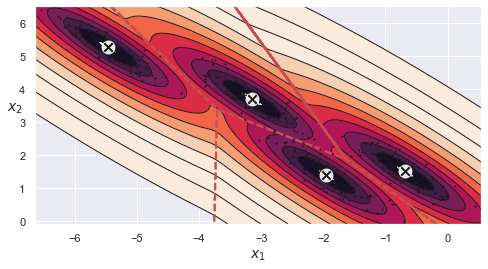

In [137]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gmm_tied, X_stretched)

#### anomaly detection

* 因為有 pdf，就可以算尾機率。  
* 所以，我們可以定義，4% 左右的產品是有缺陷的，那我就想抓出 4% 左右的 outlier. 
* 那作法就是：  
  * 算出目前資料的所有資料點所對應的 density. 
  * 將 density 由小排到大，算出 density 的 PR4 當 threshold(意義是，只有 4% 的資料， density 會比他小。那就等於排除 4% 的資料）
  * 所有資料中， density 小於此 threshold 的，都認為是 outlier

In [138]:
densities = gmm_tied.score_samples(X_stretched)
density_threshold = np.percentile(densities, 4)
anomalies = X_stretched[densities < density_threshold]
anomalies

array([[-4.63330948,  5.00361975],
       [-2.54838565,  3.64269177],
       [-0.91910995,  1.15856978],
       [-0.86486896,  0.52612946],
       [-4.89433471,  5.18742875],
       [-4.29724243,  3.8822148 ],
       [-3.57676231,  4.75833171],
       [-1.55916518,  1.98841812],
       [-0.94562645,  0.64439676],
       [-0.69821632,  0.02550763],
       [-0.33938455,  1.75038413],
       [ 0.11392436,  1.07418878],
       [-3.73846534,  4.87602497],
       [ 0.4434933 ,  0.45946803],
       [-0.89865011,  0.54233655],
       [-2.05111636,  2.20700669]])

## 細節討論

### 對 nonlinear 的 pattern 一樣沒轍

## 推薦的 workflow

## Real world examples

### [Density Estimation] moon data

* GMM 不只可以拿來做 Clustering，還可以拿來估計出一組多變量資料的 jpdf   
* 以 moon 資料集來說：

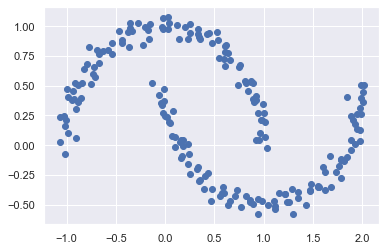

In [149]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

* 這組資料，是二維的，而且，一看就知道，這組資料不會是二元常態分配. 
* 那如果你還用分群的角度看他，你可能會想 fit 一個 k = 2 的 GMM，那他只會跟你說悲劇，因為這很明顯不能用兩個橢圓區分開來：

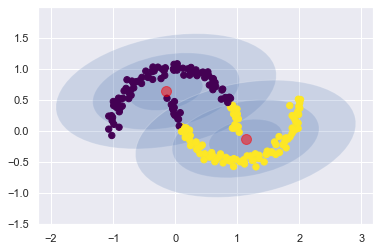

In [151]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

* 從分群的角度看回來的話，他其實是告訴我們，這個 moon data 背後的 jpdf，不會是 2 個 normal 的 mixture. 
* 那 ...，有沒有可能是多個 normal 的 mixture 呢？ 
* 就好比任意一個訊號，你可以用好幾個不同頻率的 sin, cos 來組出這個訊號一樣  
  * 任意一個一維資料的 pdf，我可以用多個不同的 normal 的線性組合把他組出來. 
  * 任意一個多維資料的 jpdf，我可以用多個不同的 多變量 normal 的線性組合把他組出來.
* 所以，我們就直接以量取勝，看 k 要取到多少時， AIC 就好棒棒了：

arg_min_bic:  10


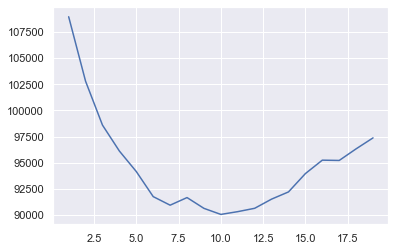

In [157]:
n_components = range(1,20)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
bics = [model.fit(data).bic(data) for model in models]
arg_min_bic = np.argmin(bics)+1

print("arg_min_bic: ", arg_min_bic)
plt.plot(n_components, bics);

* 可以得知，用 10 個不同的二元常態，可以去近似的很好  
* 那我們就來 fit 看看

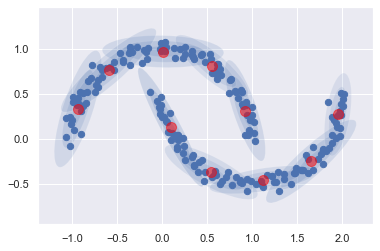

In [159]:
gmm10 = GaussianMixture(n_components=arg_min_bic, covariance_type='full', random_state=0)
plot_gmm(gmm10, Xmoon, label=False)

* 分成 10 群，然後這堆橢圓把他 fit 的很清楚  
* 現在用這個 model 來生成資料，看看生出來的點像不像 moon

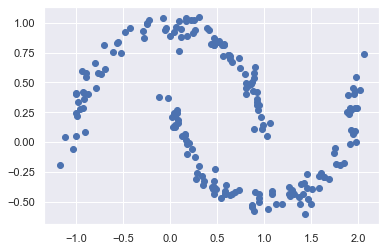

In [180]:
moon_gen, moon_cluster = gmm10.sample(200)
plt.scatter(x = moon_gen[:,0], y = moon_gen[:,1]);

* nice~ 生成的不錯

### [影像生成] Digits Number

* 假設我們已經有一組資料了(Digits Number資料集)

In [182]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

* 這筆資料有 1797 筆，每筆是 64 維的 feature. 
* 大概長成這樣：

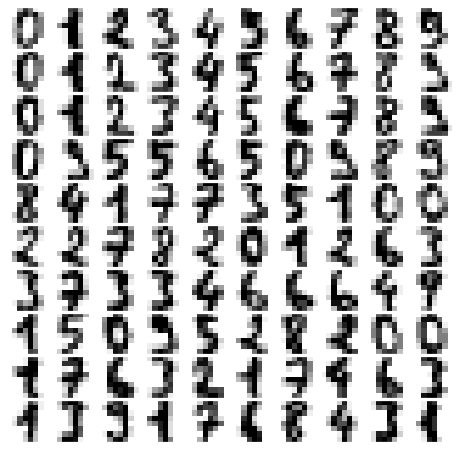

In [183]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

* 我們可以將 1797 筆的資料，用 GMM 做分群。等我們 fitting 完後，就可以自動生成資料. 
* 但像這題 64 個 feature，對 GMM 來說，也有點吃不消了  
* 因為如果你用 `covariance_type = "full"` 來估的話，參數個數就有 1/2 x 10 x (64+1) x (64+2) -1 = 21449。但資料才 1797 筆  
* 所以，我們打算  
  * 先把圖片用 PCA 壓縮 (保留 99% 的變異量)  
  * 壓縮完，再 fitting GMM  
  * 用 GMM 生成新資料  
  * 用 PCA 轉換回原尺度. 

In [184]:
# 降維
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

* 接下來，就去 fit GMM，並用 BIC 選一下需要多少個 component

arg_min_bic:  70


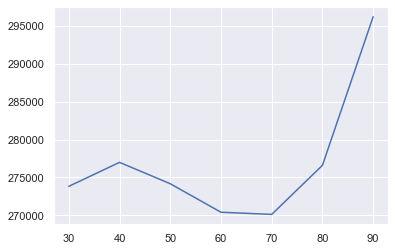

In [189]:
n_components = np.arange(30, 100, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
bics = [model.fit(data).bic(data) for model in models]

arg_min_bic = n_components[np.argmin(bics)]
print("arg_min_bic: ", arg_min_bic)
plt.plot(n_components, bics);

* 可以發現，70 個 components 可以 minimize BIC，那就來 fit 這個 model

In [190]:
gmm70 = GaussianMixture(70, covariance_type='full', random_state=0)
gmm70.fit(data)
print(gmm70.converged_)

True


* 接下來，先生成 100 張 data，再轉回圖片的尺度

(100, 41)
(100, 64)


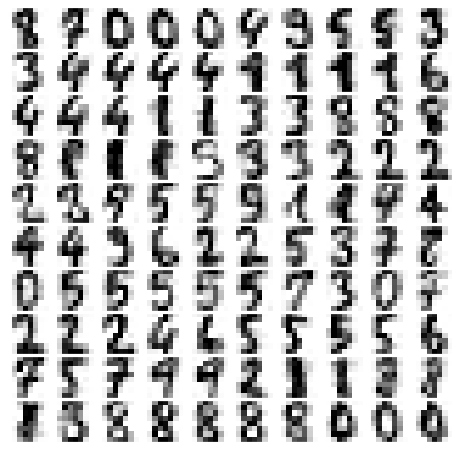

In [192]:
data_new, data_target = gmm70.sample(100)
print(data_new.shape)

digits_new = pca.inverse_transform(data_new)
print(digits_new.shape)

plot_digits(digits_new)

* 看起來還行啊～～

In [ ]:
k = 10
p = 21
(1/2)*k*(p+1)*(p+2) -1

2529.0

## 要再看的資源

* 讀完 Olivetti 資料 (p269)
* 看其他 anomaly detection 的資料. 
  * Isolation Forest: https://tomohiroliu22.medium.com/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E5%AD%B8%E7%BF%92%E7%AD%86%E8%A8%98%E7%B3%BB%E5%88%97-95-%E5%AD%A4%E7%AB%8B%E6%A3%AE%E6%9E%97-isolation-forest-7efa96213eec  
  * Minimum Covariance Determinant:  
    * https://zhuanlan.zhihu.com/p/62146814  
    * https://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html
    * https://scikit-learn.org/stable/auto_examples/covariance/plot_robust_vs_empirical_covariance.html#sphx-glr-auto-examples-covariance-plot-robust-vs-empirical-covariance-py  
    * https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html#sphx-glr-auto-examples-covariance-plot-mahalanobis-distances-py
* 範例 jupyter notebook:  
  * https://github.com/jakevdp/PythonDataScienceHandbook/tree/master/notebooks  
  * https://github.com/ageron/handson-ml2